In [23]:
#%% -------- 1. Enhanced Configuration Cell --------
import lightning.pytorch as pl
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
import splitfolders
from torch.optim.lr_scheduler import OneCycleLR
import torchmetrics
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# Hardware config
NUM_CLASSES = 4
IMG_SIZE = 224
BATCH_SIZE = 64
NUM_WORKERS = 2
PRECISION = '16-mixed'
EPOCHS = 250
LR = 3e-5
WARMUP_EPOCHS = 3
DATA_ROOT = "C:\\Users\\DELL 5540\\Desktop\\Brachial\\2nd Classification"
SPLIT_ROOT = "C:\\Users\\DELL 5540\\Desktop\\Brachial\\Split_Dataset"
SEED = 42
CLASS_NAMES = ['Type 0', 'Type 1 Neurapraxia', 'Type 2 Axonotemsis', 'Type 3 Nurotemesis']

# Reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
pl.seed_everything(SEED)

Seed set to 42


42

In [24]:
#%% -------- 2. Enhanced Data Preparation Cell --------
def prepare_dataset():
    splitfolders.ratio(
        DATA_ROOT,
        output=SPLIT_ROOT,
        seed=SEED,
        ratio=(0.7, 0.15, 0.15),
        group_prefix=None,
        move=False
    )

if not os.path.exists(os.path.join(SPLIT_ROOT, 'train')):
    prepare_dataset()

# Enhanced MRI-specific transforms
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load datasets with validation
train_dataset = ImageFolder(os.path.join(SPLIT_ROOT, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(SPLIT_ROOT, 'val'), val_transform)
test_dataset = ImageFolder(os.path.join(SPLIT_ROOT, 'test'), val_transform)

# Critical class validation
assert set(train_dataset.classes) == set(CLASS_NAMES), \
    f"Folder names {train_dataset.classes} don't match CLASS_NAMES {CLASS_NAMES}"

# Class balancing with corrected weights
class_counts = np.bincount(train_dataset.targets)
print("Class counts:", class_counts)
class_weights = len(train_dataset) / (len(class_counts) * class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float32)
samples_weights = class_weights[train_dataset.targets]
sampler = WeightedRandomSampler(samples_weights, len(samples_weights), replacement=True)

Class counts: [158 398  57  64]


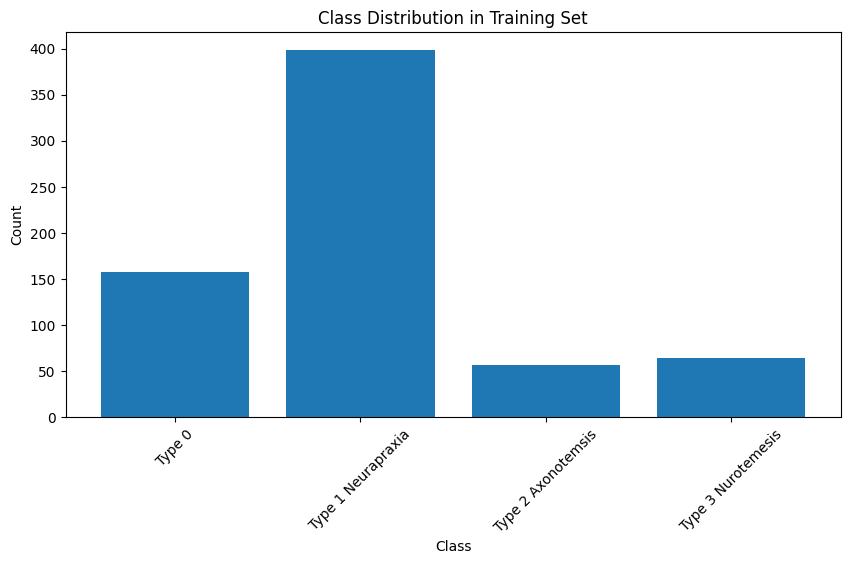

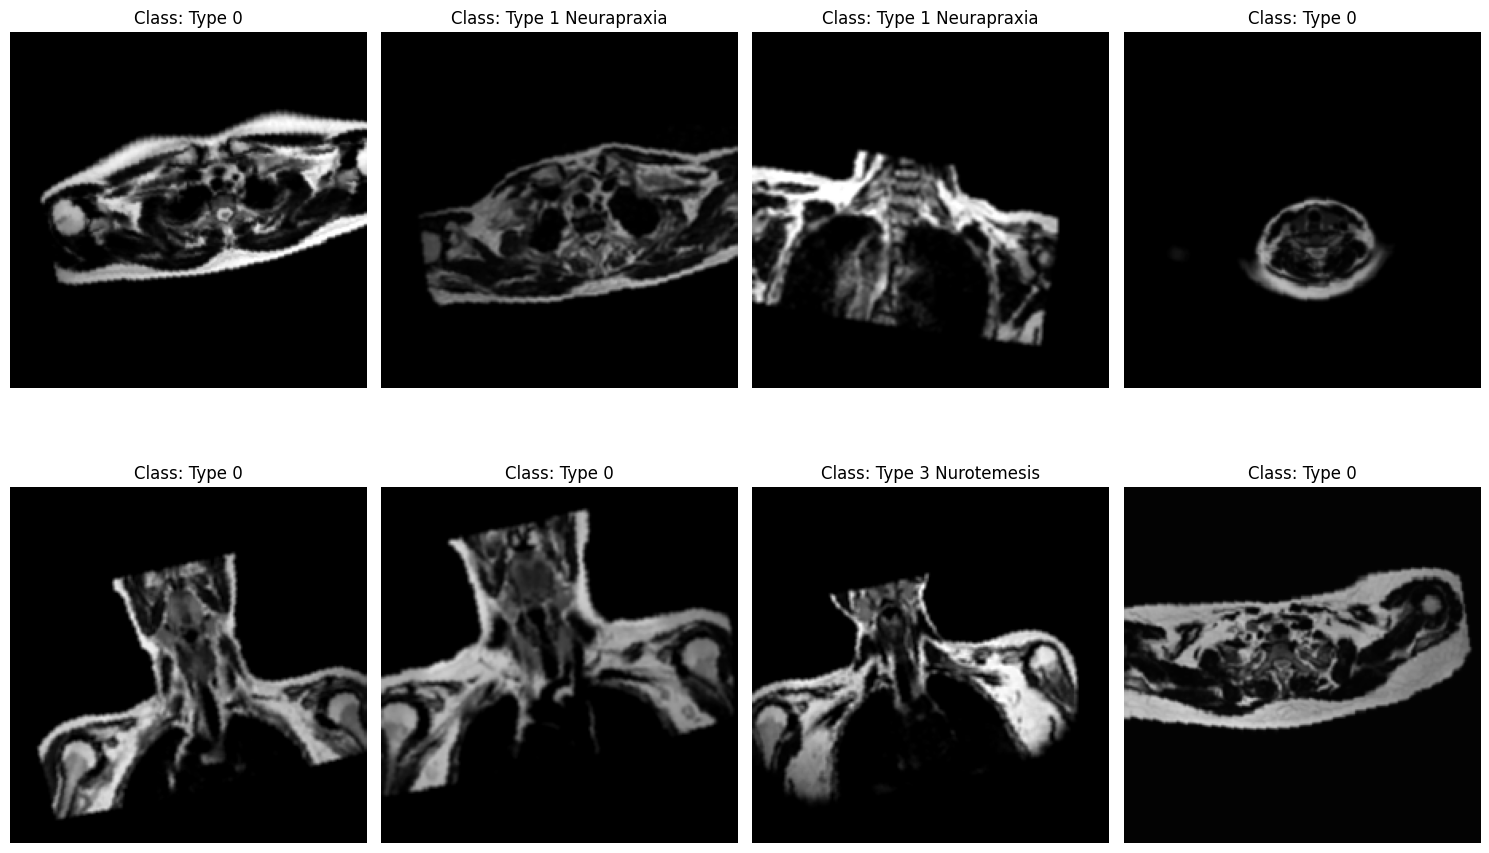

In [25]:
#%% -------- 3. Data Visualization Cell --------
def plot_class_distribution():
    counts = np.bincount(train_dataset.targets)
    plt.figure(figsize=(10, 5))
    plt.bar(CLASS_NAMES, counts)
    plt.title('Class Distribution in Training Set')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

def show_sample_images(dataset, num_images=8):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        idx = np.random.randint(len(dataset))
        img, label = dataset[idx]
        plt.subplot(2, 4, i+1)
        plt.imshow(img.permute(1, 2, 0).numpy() * 0.5 + 0.5)
        plt.title(f"Class: {CLASS_NAMES[label]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_class_distribution()
show_sample_images(train_dataset)

In [26]:
#%% -------- 4. Enhanced Model Definition Cell --------
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(
            inputs, targets,
            reduction='none',
            weight=self.alpha
        )
        pt = torch.exp(-ce_loss)
        loss = (1 - pt)**self.gamma * ce_loss
        return loss.mean()

class BrachialPlexusResMT(nn.Module):
    def __init__(self, img_size=224, patch_size=32, embed_dim=512, 
                 num_heads=8, num_layers=3, dropout=0.2):
        super().__init__()
        
        # ResNet-50 Backbone with partial unfreezing
        self.cnn_backbone = models.resnet50(pretrained=True)
        self.cnn_backbone = nn.Sequential(*list(self.cnn_backbone.children())[:-2])
        
        # Freeze initial layers
        for param in self.cnn_backbone.parameters():
            param.requires_grad = False
            
        # Unfreeze last residual block
        for param in self.cnn_backbone[-1].parameters():
            param.requires_grad = True

        # Feature adaptation
        self.feature_adapt = nn.Sequential(
            nn.Conv2d(2048, embed_dim, 1),
            nn.BatchNorm2d(embed_dim),
            nn.GELU()
        )
        
        # Positional Encoding
        self.positional_encoding = nn.Parameter(torch.randn(49, 1, embed_dim))
        
        # Transformer Encoder
        encoder_layers = TransformerEncoderLayer(
            embed_dim, num_heads, dim_feedforward=2048, dropout=dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers)
        
        # Classifier with layer norm
        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Dropout(0.5),
            nn.Linear(embed_dim, NUM_CLASSES)
        )

    def forward(self, x):
        x = self.cnn_backbone(x)
        x = self.feature_adapt(x)
        x = x.flatten(2).permute(2, 0, 1)
        x = x + self.positional_encoding
        x = self.transformer_encoder(x)
        x = x.mean(dim=0)
        return self.classifier(x)

In [27]:
#%% -------- 5. Enhanced Training Setup Cell --------
class LitModel(pl.LightningModule):
    def __init__(self, total_steps):
        super().__init__()
        self.save_hyperparameters()
        self.model = BrachialPlexusResMT()
        self.criterion = FocalLoss(alpha=class_weights.to('cuda'))
        
        # Metrics
        self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=NUM_CLASSES)
        self.val_acc = torchmetrics.Accuracy(task='multiclass', num_classes=NUM_CLASSES)
        self.train_f1 = torchmetrics.F1Score(task='multiclass', num_classes=NUM_CLASSES)
        self.val_f1 = torchmetrics.F1Score(task='multiclass', num_classes=NUM_CLASSES)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        
        self.train_acc(logits, y)
        self.train_f1(logits, y)
        self.log_dict({
            'train_loss': loss,
            'train_acc': self.train_acc,
            'train_f1': self.train_f1
        }, prog_bar=True)
        
        # Gradient monitoring
        if batch_idx % 50 == 0:
            for name, param in self.model.named_parameters():
                if param.grad is not None:
                    self.log(f"grad_{name}", param.grad.norm())
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        
        self.val_acc(logits, y)
        self.val_f1(logits, y)
        self.log_dict({
            'val_loss': loss,
            'val_acc': self.val_acc,
            'val_f1': self.val_f1
        }, prog_bar=True)
        return loss

    def configure_optimizers(self):
        # Differential learning rates
        backbone_params = []
        new_params = []
        for name, param in self.named_parameters():
            if 'cnn_backbone.layer4' in name:
                backbone_params.append(param)
            else:
                new_params.append(param)
        
        optimizer = optim.AdamW(
            [
                {'params': backbone_params, 'lr': LR/10},
                {'params': new_params, 'lr': LR}
            ],
            weight_decay=0.01
        )
        
        scheduler = {
            'scheduler': OneCycleLR(
                optimizer,
                max_lr=[LR/10, LR],
                total_steps=self.hparams.total_steps,
                pct_start=0.3
            ),
            'interval': 'step'
        }
        return [optimizer], [scheduler]

# Initialize
train_loader = DataLoader(train_dataset, BATCH_SIZE, sampler=sampler, 
                         num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, BATCH_SIZE, num_workers=NUM_WORKERS,
                       pin_memory=True)
model = LitModel(total_steps=EPOCHS*len(train_loader))

# Callbacks
checkpoint = pl.callbacks.ModelCheckpoint(
    monitor='val_f1',
    mode='max',
    filename='best-{epoch}-{val_f1:.3f}',
    save_top_k=2
)

early_stop = pl.callbacks.EarlyStopping(
    monitor='val_f1',
    patience=25,
    mode='max',
    min_delta=0.001
)

trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=EPOCHS,
    precision=PRECISION,
    callbacks=[checkpoint, early_stop],
    accumulate_grad_batches=4,
    gradient_clip_val=1.0,
    log_every_n_steps=10,
    deterministic="warn"
)

c:\Program Files\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Program Files\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Program Files\Python311\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Using 16bit Automatic Mixed Precision (AMP)
C:\Users\DELL 5540\AppData\Roaming\Pyt

In [28]:
#%% -------- 6. Training Execution Cell --------
trainer.fit(model, train_loader, val_loader)
best_model = LitModel.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params
--------------------------------------------------
0 | model     | BrachialPlexusResMT | 34.0 M
1 | criterion | FocalLoss           | 0     
2 | train_acc | MulticlassAccuracy  | 0     
3 | val_acc   | MulticlassAccuracy  | 0     
4 | train_f1  | MulticlassF1Score   | 0     
5 | val_f1    | MulticlassF1Score   | 0     
--------------------------------------------------
25.5 M    Trainable params
8.5 M     Non-trainable params
34.0 M    Total params
136.174   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\lightning\fabric\utilities\cloud_io.py:55: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


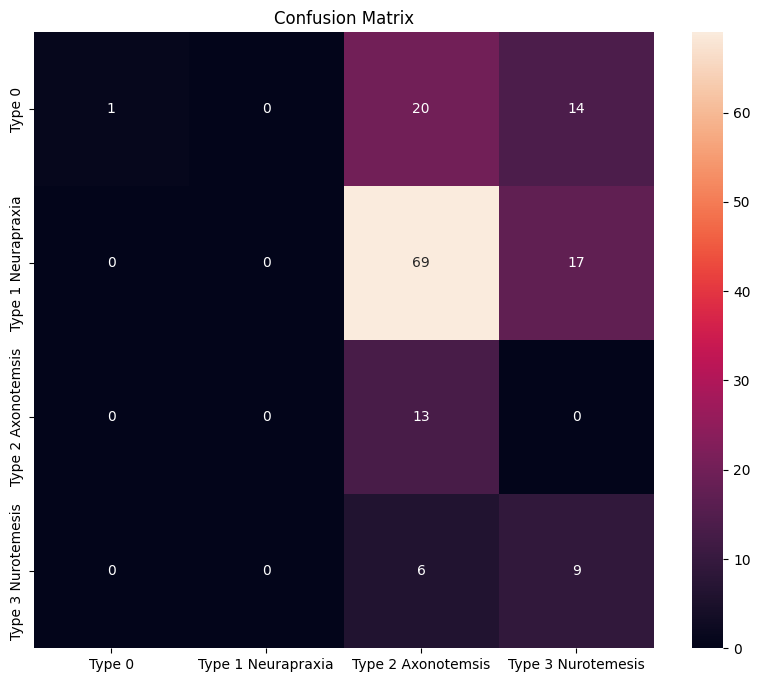

                    precision    recall  f1-score   support

            Type 0       1.00      0.03      0.06        35
Type 1 Neurapraxia       0.00      0.00      0.00        86
Type 2 Axonotemsis       0.12      1.00      0.21        13
Type 3 Nurotemesis       0.23      0.60      0.33        15

          accuracy                           0.15       149
         macro avg       0.34      0.41      0.15       149
      weighted avg       0.27      0.15      0.06       149



c:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
#%% -------- 7. Enhanced Evaluation Cell --------
test_loader = DataLoader(test_dataset, BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)

def evaluate():
    best_model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(best_model.device), y.to(best_model.device)
            logits = best_model(x)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())
    
    # Confusion Matrix
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title('Confusion Matrix')
    plt.show()
    
    # Classification Report
    print(classification_report(all_targets, all_preds, target_names=CLASS_NAMES))

evaluate()

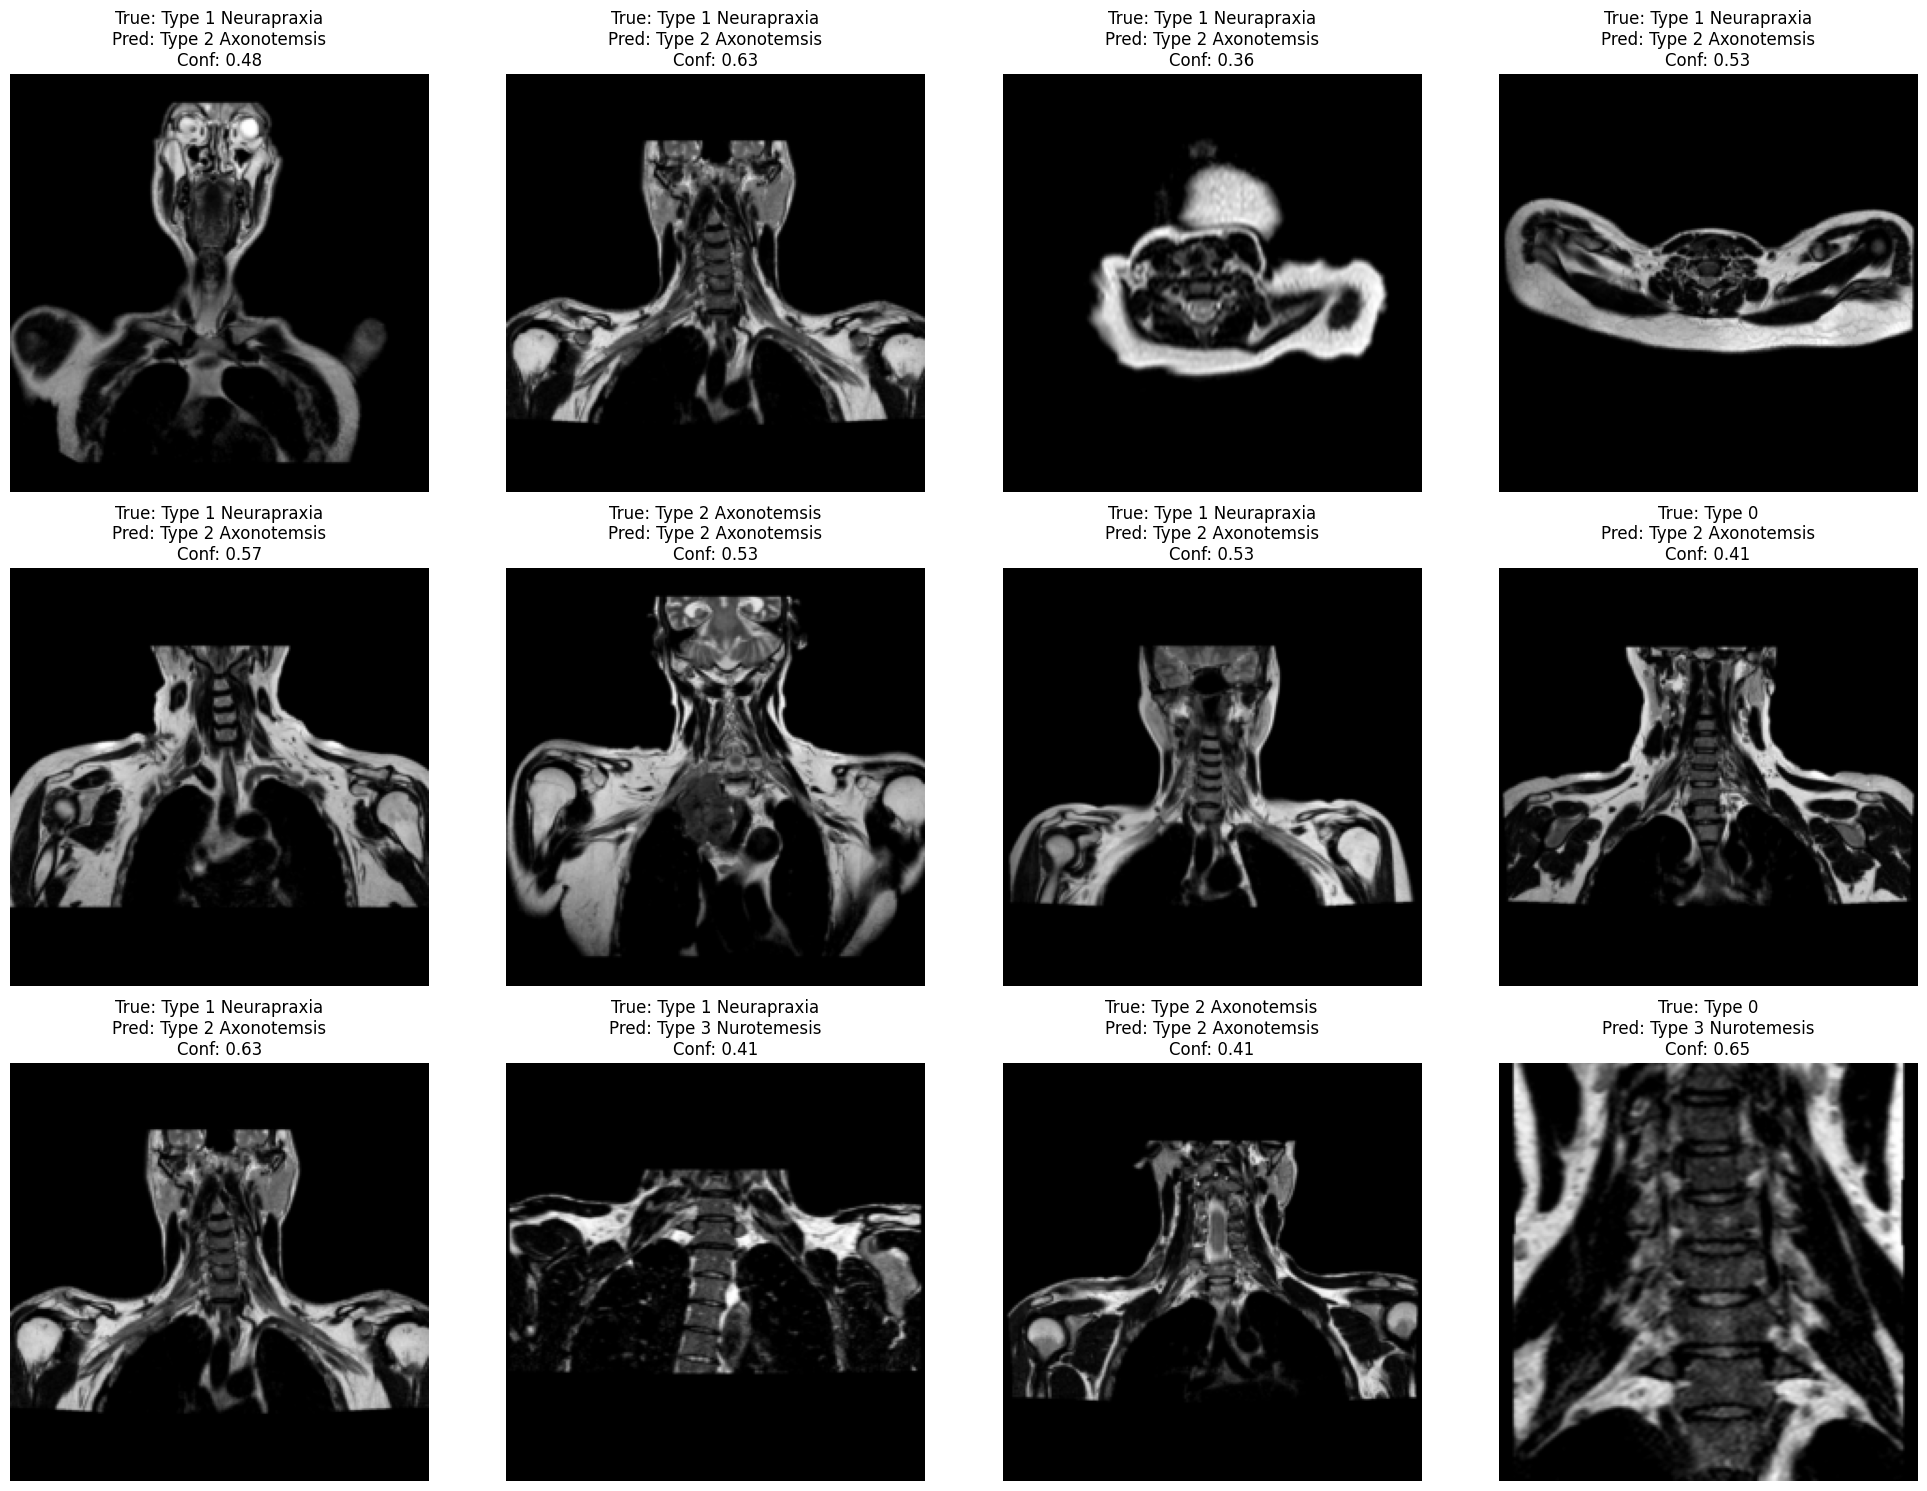

Full pipeline execution completed!


In [30]:
#%% -------- 8. Inference Visualization Cell --------
def predict_and_visualize(model, dataset, num_images=12):
    model.eval()
    plt.figure(figsize=(20, 15))
    
    for i in range(num_images):
        idx = np.random.randint(len(dataset))
        img, true_label = dataset[idx]
        img_tensor = img.unsqueeze(0).to(model.device)
        
        with torch.no_grad():
            logits = model(img_tensor)
            probs = torch.softmax(logits, dim=1)
            pred_label = torch.argmax(probs).item()
        
        img_np = img.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5
        
        plt.subplot(3, 4, i+1)
        plt.imshow(img_np, cmap='gray')
        plt.title(f"True: {CLASS_NAMES[true_label]}\nPred: {CLASS_NAMES[pred_label]}\nConf: {probs.max().item():.2f}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

predict_and_visualize(best_model, test_dataset)
print("Full pipeline execution completed!")